## 2D Double Well estimation 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import folie as fl
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy


## 2D UNBIASED Double Well Potential

### 1) The Model

Here we model the double well potential as a quartic function along x  and a parabola along y $V(x,y)= a(x^2-1)^2 + \frac{1}{2}by^2$
and constant diffusion matrix $D= d\begin{bmatrix} 1 \ \ 0 \\\ 0 \ \ 1 \end{bmatrix}$

Text(0.5, 1.0, 'Force')

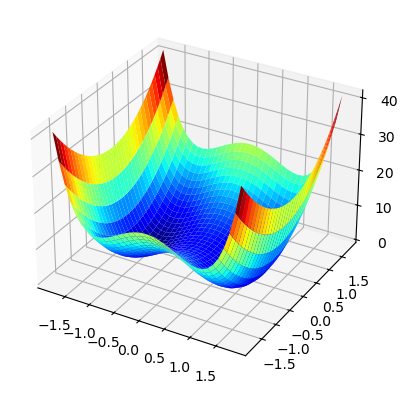

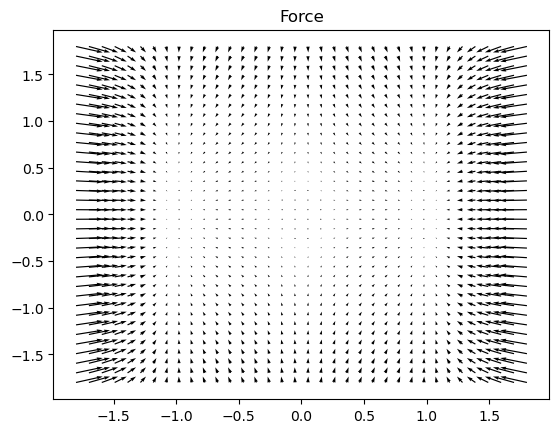

In [2]:
x = np.linspace(-1.8,1.8,36)
y = np.linspace(-1.8,1.8,36)
input=np.transpose(np.array([x,y]))

diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]) * np.eye(2,2))
a,b = 5.0, 10.0
quartic2d= fl.functions.Quartic2D(a=a,b=b)
X,Y =np.meshgrid(x,y)

# Plot potential surface 
pot = quartic2d.potential_plot(X,Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,pot, rstride=1, cstride=1,cmap='jet', edgecolor = 'none')

# Plot Force function
ff=quartic2d.force(input) # returns x and y components of the force : x_comp =ff[:,0] , y_comp =ff[:,1]
U,V = np.meshgrid(ff[:,0],ff[:,1])
fig, ax =plt.subplots()
ax.quiver(x,y,U,V)
ax.set_title('Force')


### 2) Simulation

In [ ]:
dt = 1e-3
model_simu=fl.models.overdamped.Overdamped(quartic2d,diffusion=diff_function)
simulator=fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt)


In [ ]:
# initialize positions 
ntraj=30
q0= np.empty(shape=[ntraj,2])
for i in range(ntraj):
    for j in range(2):
        q0[i][j]=0.0000
time_steps=10000
data_2d_unbias = simulator.run(time_steps, q0,save_every=1)  

In [ ]:
# Plot the resulting trajectories
fig, axs = plt.subplots()
for n, trj in enumerate(data_2d_unbias):
    axs.plot(trj["x"][:,0],trj["x"][:,1])
    axs.spines['left'].set_position('center')
    axs.spines['right'].set_color('none')
    axs.spines['bottom'].set_position('center')
    axs.spines['top'].set_color('none')
    axs.xaxis.set_ticks_position('bottom')
    axs.yaxis.set_ticks_position('left')
    axs.set_xlabel("$X(t)$")
    axs.set_ylabel("$Y(t)$")
    axs.set_title("X-Y Trajectory")
    axs.grid()

# plot x,y Trajectories in separate subplots
fig,bb =  plt.subplots(1,2)
for n, trj in enumerate(data_2d_unbias):
    bb[0].plot(trj["x"][:,0])
    bb[1].plot(trj["x"][:,1])

# Set visible  axis
    bb[0].spines['right'].set_color('none')
    bb[0].spines['bottom'].set_position('center')
    bb[0].spines['top'].set_color('none')
    bb[0].xaxis.set_ticks_position('bottom')
    bb[0].yaxis.set_ticks_position('left')
    bb[0].set_xlabel("$timestep$")
    bb[0].set_ylabel("$X(t)$")

# Set visible axis
    bb[1].spines['right'].set_color('none')
    bb[1].spines['bottom'].set_position('center')
    bb[1].spines['top'].set_color('none')
    bb[1].xaxis.set_ticks_position('bottom')
    bb[1].yaxis.set_ticks_position('left')
    bb[1].set_xlabel("$timestep$")
    bb[1].set_ylabel("$Y(t)$")

    bb[0].set_title("X Dynamics")
    bb[1].set_title("Y Dynamics")

#### 2.1) 1D Simulation with same coefficients

In [ ]:
coeff=a*np.array([1,0,-2,0,1])
free_energy = np.polynomial.Polynomial(coeff)

force_coeff=np.array([-coeff[1],-2*coeff[2],-3*coeff[3],-4*coeff[4]])
force_function = fl.functions.Polynomial(deg=3,coefficients=force_coeff)
diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]))

# Plot of Free Energy and Force
x_values = np.linspace(-1.5, 1.5, 100)
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs[0].plot(x_values,free_energy(x_values))
axs[1].plot(x_values,force_function(x_values.reshape(len(x_values),1)))
axs[0].set_title("Potential")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$V(x)$")
axs[0].grid()
axs[1].set_title("Force") 
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$F(x)$") 
axs[1].grid()

# Define model to simulate and type of simulator to use
dt=1e-3
model_simu = fl.models.overdamped.Overdamped(force_function,diffusion=diff_function)
simulator = fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt) 

# initialize positions 
q0= np.empty(ntraj)
for i in range(len(q0)):
    q0[i]=0.000
# Calculate Trajectory, n_traj and timesteps is the same as that of the 2D simulation
data_1D_unbias = simulator.run(time_steps, q0, 1)

fig, axs = plt.subplots(figsize=(14,8))
for n, trj in enumerate(data_1D_unbias):
    axs.plot(trj["x"])
    axs.set_title("Trajectory")
    # axs[1].plot(xmax[:, n])
    axs.set_xlabel("$timestep$")
    axs.set_ylabel("$x(t)$")
    axs.grid()

### 3) Fitting 

#### 3.1) Projecting onto the x Coordinate and comparison with 1D simulation


In [ ]:
xdata = fl.data.trajectories.Trajectories(dt=dt) 
for n, trj in enumerate(data_2d_unbias):
    xdata.append(fl.data.trajectories.Trajectory(dt, trj["x"][:,0].reshape(len(trj["x"][:,0]),1)))
xfa = np.linspace(-1.3, 1.3, 75)
xforce = -4*a*(xfa** 3 - xfa)

##### 3.1.1) Fitting with exact model

In [ ]:
# Parameters of the training

trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
trainmodelx=fl.models.Overdamped(force = deepcopy(trainforce),diffusion=deepcopy(traindiff), has_bias=None)

KM_estimator = fl.KramersMoyalEstimator(deepcopy(trainmodelx), n_jobs=4)
Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodelx)),n_jobs=4)
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodelx)),n_jobs=4)
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodelx)),n_jobs=4)
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodelx)),n_jobs=4)

KM_res=KM_estimator.fit_fetch(xdata)
Eul_res=Eul_estimator.fit_fetch(xdata)
Eln_res=Eln_estimator.fit_fetch(xdata)
Ksl_res=Ksl_estimator.fit_fetch(xdata)
Drz_res=Drz_estimator.fit_fetch(xdata)

res_vec = [KM_res,Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig, axs = plt.subplots(1, 2, figsize=(14, 8))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()


#Plot exact quantities 

axs[0].plot(xfa, xforce, label="Exact")

# #Plot inferred quantities 

names = ["KM","Euler", "Elerian", "Kessler", "Drozdov"]
markers = ["x", "1","2","3","|"]
for i in range(len(names)):
     
    axs[0].plot(xfa, res_vec[i].drift(xfa.reshape(-1, 1)), markers[i],label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), markers[i],label=names[i])
    print(names[i],res_vec[i].coefficients)
axs[0].legend()
axs[1].legend()


fitting of the 1D data 


In [ ]:
trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
trainmodelx=fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodelx)),n_jobs =4)   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodelx)),n_jobs =4) # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodelx)),n_jobs =4) # made by the previous estimator. So in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodelx)),n_jobs =4)


Eul_res=Eul_estimator.fit_fetch(data_1D_unbias)
Eln_res=Eln_estimator.fit_fetch(data_1D_unbias)
Ksl_res=Ksl_estimator.fit_fetch(data_1D_unbias)
Drz_res=Drz_estimator.fit_fetch(data_1D_unbias)
res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # makes a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(xfa, xforce,label='Exact')
ax[1].plot(xfa,0.5*np.ones(xfa.shape), label = 'Exact')

for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.drift(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
    print(name, res.coefficients)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion coefficient')
ax[0].legend()
ax[1].legend()
fig.suptitle('Order 3 Polynomial fitting of 1D data')

##### 3.1.2) Fitting with B-splines

Fitting with 4-knots B-splines

In [ ]:
n_knots=4
xfa = np.linspace(-1.3, 1.3, 75)
domain = fl.MeshedDomain.create_from_range(np.linspace(xdata.stats.min,xdata.stats.max , n_knots).ravel())
splines_trainmodelx = fl.models.Overdamped(force = fl.functions.BSplinesFunction(domain), diffusion= fl.functions.BSplinesFunction(domain), has_bias = None)

KM_estimator = fl.KramersMoyalEstimator(deepcopy(splines_trainmodelx), n_jobs=4)
Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(splines_trainmodelx)),n_jobs=4)
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(splines_trainmodelx)),n_jobs=4)
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(splines_trainmodelx)),n_jobs=4)
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(splines_trainmodelx)),n_jobs=4)

KM_res=KM_estimator.fit_fetch(xdata)
Eul_res=Eul_estimator.fit_fetch(xdata)
Eln_res=Eln_estimator.fit_fetch(xdata)
Ksl_res=Ksl_estimator.fit_fetch(xdata)
Drz_res=Drz_estimator.fit_fetch(xdata)

res_vec = [KM_res,Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig, axs = plt.subplots(1, 2, figsize=(14, 8))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()


#Plot exact quantities 

axs[0].plot(xfa, xforce, label="Exact")

# #Plot inferred quantities 

names = ["KM","Euler", "Elerian", "Kessler", "Drozdov"]
markers = ["x", "1","2","3","|"]
for i in range(len(names)):

    axs[0].plot(xfa, res_vec[i].drift(xfa.reshape(-1, 1)), markers[i],label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), markers[i],label=names[i])
    print(names[i],res_vec[i].coefficients)
axs[0].legend()
axs[1].legend()

fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')



fitting of the 1D data with Bsplines

In [ ]:
n_knots=4
xfa = np.linspace(-1.3, 1.3, 75)
domain = fl.MeshedDomain.create_from_range(np.linspace(data_1D_unbias.stats.min,data_1D_unbias.stats.max , n_knots).ravel())
splines_trainmodelx_1d = fl.models.OverdampedSplines1D(domain=domain)

KM_estimator = fl.KramersMoyalEstimator(deepcopy(splines_trainmodelx_1d), n_jobs=4)
Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(splines_trainmodelx_1d)),n_jobs=4)
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(splines_trainmodelx_1d)),n_jobs=4)
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(splines_trainmodelx_1d)),n_jobs=4)
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(splines_trainmodelx_1d)),n_jobs=4)

KM_res=KM_estimator.fit_fetch(data_1D_unbias)
Eul_res=Eul_estimator.fit_fetch(data_1D_unbias)
Eln_res=Eln_estimator.fit_fetch(data_1D_unbias)
Ksl_res=Ksl_estimator.fit_fetch(data_1D_unbias)
Drz_res=Drz_estimator.fit_fetch(data_1D_unbias)

res_vec = [KM_res,Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig, axs = plt.subplots(1, 2, figsize=(14, 8))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()


#Plot exact quantities 

axs[0].plot(xfa, xforce, label="Exact")

# #Plot inferred quantities 

names = ["KM","Euler", "Elerian", "Kessler", "Drozdov"]
markers = ["x", "1","2","3","|"]
for i in range(len(names)):
     
    axs[0].plot(xfa, res_vec[i].drift(xfa.reshape(-1, 1)), markers[i],label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), markers[i],label=names[i])
    print(names[i],res_vec[i].coefficients)
axs[0].legend()
axs[1].legend()

fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')
fig.suptitle('1D data B-spline Fitting with '+str(n_knots)+ ' knots')


#### 3.2) Projection onto y coordinate

In [ ]:
ydata = fl.data.trajectories.Trajectories(dt=dt) 
for n, trj in enumerate(data_2d_unbias):
    ydata.append(fl.data.trajectories.Trajectory(dt,trj["x"][:,1].reshape(len(trj["x"][:,1]),1)))
yfa = np.linspace(-1.3, 1.3, 75)
yforce= -b*yfa

##### 3.2.1) Fitting with exact  Ornstein–Uhlenbeck model

In [ ]:

# Parameters of the training

trainmodely=fl.models.overdamped.OrnsteinUhlenbeck(has_bias=None)

KM_estimator = fl.KramersMoyalEstimator(deepcopy(trainmodely), n_jobs=4)
Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodely)),n_jobs=4)
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodely)),n_jobs=4)
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodely)),n_jobs=4)
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodely)),n_jobs=4)

KM_res=KM_estimator.fit_fetch(deepcopy(ydata))
Eul_res=Eul_estimator.fit_fetch(deepcopy(ydata))
Eln_res=Eln_estimator.fit_fetch(deepcopy(ydata))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(ydata))
Drz_res=Drz_estimator.fit_fetch(deepcopy(ydata))
res_vecy = [KM_res,Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig, axs = plt.subplots(1, 2, figsize=(14, 8))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()


#Plot exact quantities 

axs[0].plot(xfa, yforce, label="Exact")

# #Plot inferred quantities 

names = ["KM","Euler", "Elerian", "Kessler", "Drozdov"]
markers = ["x", "1","2","3","|"]
for i in range(len(names)):
     
    axs[0].plot(xfa, res_vecy[i].drift(xfa.reshape(-1, 1)), markers[i],label=names[i] )
    axs[1].plot(xfa, res_vecy[i].diffusion(xfa.reshape(-1, 1)), markers[i],label=names[i])
    print(names[i],res_vecy[i].coefficients)
axs[0].legend()
axs[1].legend()

#### 3.3) Projecting onto $1^{st}$ and $3^{rd}$ quadrant bisectrix

In [ ]:
theta = np.pi/4
u = np.array([np.cos(theta),np.sin(theta)])
u_norm = (1/np.linalg.norm(u,2))*u
qdata = fl.data.trajectories.Trajectories(dt=dt) 
fig, axs = plt.subplots()
for n, trj in enumerate(data_2d_unbias):
    proj_traj = (1/np.linalg.norm(u,2))*(trj["x"][:,0]+trj["x"][:,1]).reshape(len(trj["x"][:,0]),1)
    qdata.append(fl.data.trajectories.Trajectory(dt, proj_traj ))
    axs.plot(qdata[n]["x"])
    axs.set_xlabel('timestep')
    axs.set_ylabel('q')
    axs.set_title('Dynamics along u'+str(u_norm)+'direction')


##### 3.3.1) Fitting with splines

In [ ]:
qfa = np.linspace(qdata.stats.min , qdata.stats.max,75)
n_knots= 4
domain = fl.MeshedDomain.create_from_range(np.linspace(qdata.stats.min , qdata.stats.max , n_knots).ravel())
trainmodelq = fl.models.Overdamped(fl.functions.BSplinesFunction(domain), diffusion =fl.functions.BSplinesFunction(domain), has_bias=None)

KM_estimator = fl.KramersMoyalEstimator(deepcopy(trainmodelq), n_jobs=4)
Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodelq)), n_jobs=4)  # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodelq)), n_jobs=4)  # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodelq)), n_jobs=4) # made by the previuos estimator and so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodelq)), n_jobs=4) # which is the reason why the loop checking if the values are different in the following cell exists

KM_res=KM_estimator.fit_fetch(qdata)
Eul_res=Eul_estimator.fit_fetch(qdata)
Eln_res=Eln_estimator.fit_fetch(qdata)
Ksl_res=Ksl_estimator.fit_fetch(qdata)
Drz_res=Drz_estimator.fit_fetch(qdata)

res_vecq = [KM_res,Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 


fig, axs = plt.subplots(1, 2, figsize=(14, 8))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()


# #Plot inferred quantities 

names = ["KM","Euler", "Elerian", "Kessler", "Drozdov"]
markers = ["x", "1","2","3","|"]
for i in range(len(names)):

    axs[0].plot(xfa, res_vecq[i].drift(xfa.reshape(-1, 1)), markers[i],label=names[i] )
    axs[1].plot(xfa, res_vecq[i].diffusion(xfa.reshape(-1, 1)), markers[i],label=names[i])
    print(names[i],res_vecq[i].coefficients)
axs[0].legend()
axs[1].legend()

## 2D BIASED Double Well Potential

### 1) Model 

Here we model the double well potential as a quartic function along x and a parabola along y $V(x,y)= a(x^2-1)^2 + \frac{1}{2}by^2$
and constant diffusion matrix $D= d\begin{bmatrix} 1 \ \ 0 \\\ 0 \ \ 1 \end{bmatrix} $ 


In [ ]:
x = np.linspace(-1.8,1.8,36)
y = np.linspace(-1.8,1.8,36)
input=np.transpose(np.array([x,y]))

diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]) * np.eye(2,2))
a,b = 0.5, 1.0

quartic2d = fl.functions.Quartic2D(a=a, b=b)
X, Y = np.meshgrid(x, y)

# Plot potential surface
pot = quartic2d.potential_plot(X, Y)
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.plot_surface(X, Y, pot, rstride=1, cstride=1, cmap="jet", edgecolor="none")

# Plot Force function
ff = quartic2d.drift(input)  # returns x and y components of the force : x_comp =ff[:,0] , y_comp =ff[:,1]
U, V = np.meshgrid(ff[:, 0], ff[:, 1])
fig, ax = plt.subplots()
ax.quiver(x, y, U, V)
ax.set_title("Force")

On top of that we apply a linear bias along the chosen collective variable $q(x,y)= x+y$ feeding to the biased 1DColval simulator class the collective variable as a function and its gradient as an explicit array

### 2) Simulation

In order to bias with ABMD along a selected collective variable $\textit{colvar} : \: q(x,y)$ user must provide both the function of original variables and its gradient 

In [ ]:
def colvar (x,y):
    gradient = np.array([1,1])
    return x + y , gradient
dt = 1e-3
model_simu=fl.models.overdamped.Overdamped(quartic2d,diffusion=diff_function)
simulator=fl.simulations.ABMD_2D_to_1DColvar_Simulator(fl.simulations.EulerStepper(model_simu), dt,colvar=colvar,k=10.0,qstop=1.5)


In [ ]:
# initialize positions 
ntraj=30
q0= np.empty(shape=[ntraj,2])
for i in range(ntraj):
    for j in range(2):
        q0[i][j]=-1.2
time_steps=5000
data_2d_bias = simulator.run(time_steps, q0,save_every=1)  


In [ ]:
# Plot the resulting trajectories
fig, axs = plt.subplots()
for n, trj in enumerate(data_2d_bias):
    axs.plot(trj["x"][:,0],trj["x"][:,1])
    axs.spines['left'].set_position('center')
    axs.spines['right'].set_color('none')
    axs.spines['bottom'].set_position('center')
    axs.spines['top'].set_color('none')
    axs.xaxis.set_ticks_position('bottom')
    axs.yaxis.set_ticks_position('left')
    axs.set_xlabel("$X(t)$")
    axs.set_ylabel("$Y(t)$")
    axs.set_title("X-Y Trajectory")
    axs.grid()

# plot x,y Trajectories in separate subplots
fig,bb =  plt.subplots(1,2)
for n, trj in enumerate(data_2d_bias):
    bb[0].plot(trj["x"][:,0])
    bb[1].plot(trj["x"][:,1])


# Set visible  axis
    bb[0].spines['right'].set_color('none')
    bb[0].spines['bottom'].set_position('center')
    bb[0].spines['top'].set_color('none')
    bb[0].xaxis.set_ticks_position('bottom')
    bb[0].yaxis.set_ticks_position('left')
    bb[0].set_xlabel("$timestep$")
    bb[0].set_ylabel("$X(t)$")

# Set visible axis
    bb[1].spines['right'].set_color('none')
    bb[1].spines['bottom'].set_position('center')
    bb[1].spines['top'].set_color('none')
    bb[1].xaxis.set_ticks_position('bottom')
    bb[1].yaxis.set_ticks_position('left')
    bb[1].set_xlabel("$timestep$")
    bb[1].set_ylabel("$Y(t)$")

    bb[0].set_title("X Dynamics")
    bb[1].set_title("Y Dynamics")

### 3) Fitting

#### 3.1) Projecting onto the x Coordinate 


In [ ]:
xdata_bias = fl.data.trajectories.Trajectories(dt=dt) 

for n, trj in enumerate(data_2d_bias):
    xdata_bias.append(fl.data.trajectories.Trajectory(dt, trj["x"][:,0].reshape(len(trj["x"][:,0]),1), bias=trj["bias"][:,:1].reshape(len(trj["bias"][:,1]),1)))

xfa = np.linspace(-1.3, 1.3, 75)
xforce = -4*a*(xfa** 3 - xfa)


##### 3.1.1) Fitting with exact model

In [ ]:
# Parameters of the training

trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
trainmodelx=fl.models.Overdamped(force = deepcopy(trainforce),diffusion=deepcopy(traindiff), has_bias=True)

KM_estimator = fl.KramersMoyalEstimator(deepcopy(trainmodelx), n_jobs=4)
Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodelx)),n_jobs=4)
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodelx)),n_jobs=4)
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodelx)),n_jobs=4)
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodelx)),n_jobs=4)

KM_res=KM_estimator.fit_fetch(deepcopy(xdata_bias))
Eul_res=Eul_estimator.fit_fetch(deepcopy(xdata_bias))
Eln_res=Eln_estimator.fit_fetch(deepcopy(xdata_bias))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(xdata_bias))
Drz_res=Drz_estimator.fit_fetch(deepcopy(xdata_bias))

res_vec = [KM_res,Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig, axs = plt.subplots(1, 2, figsize=(14, 8))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()


#Plot exact quantities 

axs[0].plot(xfa, xforce, label="Exact")

# #Plot inferred quantities 

names = ["KM","Euler", "Elerian", "Kessler", "Drozdov"]
markers = ["x", "1","2","3","|"]
for i in range(len(names)):
    
    axs[0].plot(xfa, res_vec[i].drift(xfa.reshape(-1, 1)), markers[i],label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), markers[i],label=names[i])
    print(names[i],res_vec[i].coefficients)
axs[0].legend()
axs[1].legend()



##### 3.1.2) Fitting with splines

In [ ]:
n_knots=4
xfa = np.linspace(-1.3, 1.3, 75)
domain = fl.MeshedDomain.create_from_range(np.linspace(xdata_bias.stats.min, xdata_bias.stats.max , n_knots).ravel())
splines_trainmodelx = fl.models.Overdamped(force = fl.functions.BSplinesFunction(domain), diffusion= fl.functions.BSplinesFunction(domain), has_bias = True)

KM_estimator = fl.KramersMoyalEstimator(deepcopy(splines_trainmodelx), n_jobs=4)
Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(splines_trainmodelx)),n_jobs=4)
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(splines_trainmodelx)),n_jobs=4)
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(splines_trainmodelx)),n_jobs=4)
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(splines_trainmodelx)),n_jobs=4)

KM_res=KM_estimator.fit_fetch(xdata_bias)
Eul_res=Eul_estimator.fit_fetch(xdata_bias)
Eln_res=Eln_estimator.fit_fetch(xdata_bias)
Ksl_res=Ksl_estimator.fit_fetch(xdata_bias)
Drz_res=Drz_estimator.fit_fetch(xdata_bias)

res_vec = [KM_res,Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig, axs = plt.subplots(1, 2, figsize=(14, 8))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()


#Plot exact quantities 

axs[0].plot(xfa, xforce, label="Exact")

# #Plot inferred quantities 

names = ["KM","Euler", "Elerian", "Kessler", "Drozdov"]
markers = ["x", "1","2","3","|"]
for i in range(len(names)):

    axs[0].plot(xfa, res_vec[i].drift(xfa.reshape(-1, 1)), markers[i],label=names[i] )
    axs[1].plot(xfa, res_vec[i].diffusion(xfa.reshape(-1, 1)), markers[i],label=names[i])
    print(names[i],res_vec[i].coefficients)
axs[0].legend()
axs[1].legend()

fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')



#### 3.2) Projecting along y coordinate 

In [ ]:
ydata_bias = fl.data.trajectories.Trajectories(dt=dt) 

for n, trj in enumerate(data_2d_bias):
    ydata_bias.append(fl.data.trajectories.Trajectory(dt, trj["x"][:,1].reshape(len(trj["x"][:,1]),1), bias=trj["bias"][:,1].reshape(len(trj["bias"][:,1]),1)))

yfa = np.linspace(-1.3, 1.3, 75)
yforce = -b*yfa

In [ ]:

# Parameters of the training

trainmodely=fl.models.overdamped.OrnsteinUhlenbeck(has_bias=True)

KM_estimator = fl.KramersMoyalEstimator(deepcopy(trainmodely), n_jobs=4)
Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodely)),n_jobs=4)
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodely)),n_jobs=4)
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodely)),n_jobs=4)
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodely)),n_jobs=4)

KM_res=KM_estimator.fit_fetch(deepcopy(ydata_bias))
Eul_res=Eul_estimator.fit_fetch(deepcopy(ydata_bias))
Eln_res=Eln_estimator.fit_fetch(deepcopy(ydata_bias))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(ydata_bias))
Drz_res=Drz_estimator.fit_fetch(deepcopy(ydata_bias))

res_vecy = [KM_res,Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig, axs = plt.subplots(1, 2, figsize=(14, 8))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()


#Plot exact quantities 

axs[0].plot(xfa, yforce, label="Exact")

# #Plot inferred quantities 

names = ["KM","Euler", "Elerian", "Kessler", "Drozdov"]
markers = ["x", "1","2","3","|"]
for i in range(len(names)):
     
    axs[0].plot(xfa, res_vecy[i].drift(xfa.reshape(-1, 1)), markers[i],label=names[i] )
    axs[1].plot(xfa, res_vecy[i].diffusion(xfa.reshape(-1, 1)), markers[i],label=names[i])
    print(names[i],res_vecy[i].coefficients)
axs[0].legend()
axs[1].legend()

#### 3.3) Projecting along biased coordinate

In [ ]:
theta = np.pi/4
u = np.array([np.cos(theta),np.sin(theta)])
u_norm = (1/np.linalg.norm(u,2))*u
qdata_bias = fl.data.trajectories.Trajectories(dt=dt) 
fig, axs = plt.subplots()
for n, trj in enumerate(data_2d_bias):
    proj_bias=(trj["bias"][:,0]+trj["bias"][:,1]).reshape(len(trj["bias"][:,0]),1)
    proj_traj = (1/np.linalg.norm(u,2))*(trj["x"][:,0]+trj["x"][:,1]).reshape(len(trj["x"][:,0]),1)
    qdata_bias.append(fl.data.trajectories.Trajectory(dt, proj_traj, bias = proj_bias))
    axs.plot(qdata_bias[n]["x"])
    axs.set_xlabel('timestep')
    axs.set_ylabel('q')
    axs.set_title('Dynamics along u'+str(u_norm)+'direction')


In [ ]:

qfa = np.linspace(qdata_bias.stats.min , qdata_bias.stats.max,75)
n_knots= 5
domain = fl.MeshedDomain.create_from_range(np.linspace(qdata_bias.stats.min , qdata_bias.stats.max , n_knots).ravel())
trainmodelq = fl.models.Overdamped(fl.functions.BSplinesFunction(domain),has_bias=True)

KM_estimator = fl.KramersMoyalEstimator(deepcopy(trainmodelq), n_jobs=4)
Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodelq)), n_jobs=4)  # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodelq)), n_jobs=4)  # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodelq)), n_jobs=4) # made by the previuos estimator and so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodelq)), n_jobs=4) # which is the reason why the loop checking if the values are different in the following cell exists

KM_res=KM_estimator.fit_fetch(qdata_bias)
Eul_res=Eul_estimator.fit_fetch(qdata_bias)
Eln_res=Eln_estimator.fit_fetch(qdata_bias)
Ksl_res=Ksl_estimator.fit_fetch(qdata_bias)
Drz_res=Drz_estimator.fit_fetch(qdata_bias)

res_vecq = [KM_res,Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 


fig, axs = plt.subplots(1, 2, figsize=(14, 8))
axs[0].set_title("Force")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$F(x)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$D(x)$") 
axs[1].grid()


# #Plot inferred quantities 

names = ["KM","Euler", "Elerian", "Kessler", "Drozdov"]
markers = ["x", "1","2","3","|"]
for i in range(len(names)):
     
    axs[0].plot(xfa, res_vecq[i].drift(qfa.reshape(-1, 1)), markers[i],label=names[i] )
    axs[1].plot(xfa, res_vecq[i].diffusion(qfa.reshape(-1, 1)), markers[i],label=names[i])
    print(names[i],res_vecq[i].coefficients)
axs[0].legend()
axs[1].legend()
